# Analyze Model Behaviour of Classification

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_cls.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1P0xLAO4PaKFaeJIQcYxJqOJt-0DtDD66)

* In this notebook, we will show how to analyze the model behaviour based using MOVAL.
<br>
* More specifically, we show an example of analyzing model behaviour under domain shifts on CIFAR10-LT based on ResNet. We will utilize the calculated logits on test dataset with sythesized motion blur condition.
<br>
* We will visualize the calibrated confidence scores as an proper indication of model failure.

In [2]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib

In [3]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import moval
import scipy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
print(f"The installed MOVAL verision is {moval.__version__}")
print(f"The installed seaborn verision is {sns.__version__}")

The installed MOVAL verision is 0.2.5
The installed seaborn verision is 0.12.0


## Load the data

In [5]:
# download the data, which we used for MICCAI 2022

output = "data_moval.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=139pqxkG2ccIFq6qNArnFJWQ2by2Spbxt&export=download"
    output = "data_moval.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [6]:
# download the coresponding image data

output = "img_cifar.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1B5GH2KUnYKybj6gshGbkpGsg8lT5LVFt&export=download"
    output = "img_cifar.zip"
    gdown.download(url, output, quiet=False)

directory_data = "img_cifar"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [7]:
ls

analysis_cls.ipynb    data_moval_supp.zip   img_cifar/
analysis_seg2d.ipynb  estim_cls.ipynb       img_cifar.zip
analysis_seg3d.ipynb  estim_seg2d.ipynb     img_prostate/
data_moval/           estim_seg3d.ipynb     img_prostate.zip
data_moval.zip        img_cardiac/
data_moval_supp/      img_cardiac.zip


In [8]:
# now I am playing with cifar10 classification
val_data =  "data_moval/cifar10results/predictions_val.csv"
test_data = "data_moval/cifar10results/predictions_val_motion_blur.csv"
# validation data
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
# logits is of shape ``(n, d)``
# gt is of shape ``(n, )``

# test data
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)

In [9]:
# Here I want to split the test data such that they are not overlapped.
import random
random.seed(79)
test_ind = list(range(10000))
random.shuffle(test_ind)
#
val_ind = test_ind[:3000]
testc_indx_5 = [x+40000 for x in test_ind[3000:]]
testc_indxs = [testc_indx_5]
#

In [10]:
logits_val = logits[val_ind, :]
gt_val = gt[val_ind]
#
logits_tests = []
gt_tests = []
#
for testc_indx in testc_indxs:
    #
    logits_tests.append(logits_test[testc_indx, :])
    gt_tests.append(gt_test[testc_indx])

In [11]:
print(f"The validation predictions, ``logits`` are of shape (n, d), which are now {logits_val.shape}")
print(f"The validation labels, ``gt`` are of shape (n, ), which are now {gt_val.shape}\n")
print(f"The number of test conditions is {len(logits_tests)}")
print(f"The test predictions, ``logits_test`` are of shape (n', d), which are now {logits_tests[0].shape}")
print(f"The test labels, ``gt_test`` are of shape (n', ), which are now {gt_tests[0].shape}")

The validation predictions, ``logits`` are of shape (n, d), which are now (3000, 10)
The validation labels, ``gt`` are of shape (n, ), which are now (3000,)

The number of test conditions is 1
The test predictions, ``logits_test`` are of shape (n', d), which are now (7000, 10)
The test labels, ``gt_test`` are of shape (n', ), which are now (7000,)


In [12]:
# Load the image data
imgc_path = "img_cifar/img_cifar/motion_blur.npy"
imgc_load = np.load(imgc_path)
imgc_load_5 = imgc_load[testc_indx_5, :, :, :]

In [13]:
print(f"Img cifar under domain shifts is of shape {imgc_load_5.shape}")

Img cifar under domain shifts is of shape (7000, 32, 32, 3)


## MOVAL estimation

In [14]:
moval_options = []
moval_options.append(['ac-model', 'classification', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'classification', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'classification', 'max_class_probability-conf', True])
moval_options.append(['ts-atc-model', 'classification', 'entropy-conf', True])

In [15]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for classification tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of shape ``(n, d)`` for classification. 
        gt: The cooresponding annotation of shape ``(n, )`` for classification.
        logits_tests:  A list of m test conditions ``(n', d)``.
        gt_test: The cooresponding annotation of a list of m ``(n', )``.

    Returns:
        err_test: A list of m test err.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                metric = "accuracy",
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    err_tests = []
    for k_test in range(len(logits_tests)):

        _logits_test = logits_tests[k_test]
        _gt_test = gt_tests[k_test]
        
        estim_acc_test = moval_model.estimate(_logits_test)
        pred_test = np.argmax(_logits_test, axis = 1)
        err_test = np.abs( np.sum(_gt_test == pred_test) / len(_gt_test) - estim_acc_test )
        err_tests.append(err_test)

    return err_tests, moval_model

In [16]:
_, moval_model_MCP = test_cls(
        estim_algorithm = moval_options[0][0], 
        mode = moval_options[0][1], 
        confidence_scores = moval_options[0][2],
        class_specific = moval_options[0][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )
#
_, moval_model_baseline = test_cls(
        estim_algorithm = moval_options[1][0], 
        mode = moval_options[1][1], 
        confidence_scores = moval_options[1][2],
        class_specific = moval_options[1][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )
#
_, moval_model_cs = test_cls(
        estim_algorithm = moval_options[2][0], 
        mode = moval_options[2][1], 
        confidence_scores = moval_options[2][2],
        class_specific = moval_options[2][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )
#
_, moval_model_cs_entropy = test_cls(
        estim_algorithm = moval_options[3][0], 
        mode = moval_options[3][1], 
        confidence_scores = moval_options[3][2],
        class_specific = moval_options[3][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )

Starting optimizing for model ac-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Calculating and saving the fitted case-wise performance...


/Users/zejuli/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zejuli/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 3000 samples...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param for class 8, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 9, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of param for class 7, trying more initial states...
Tried 1/5 times.
Tried 2/5 times.
Tried 3/5 times.
Tried 4/5 times.
Tried 5/5 times.
Not satisfied with initial optimization results of para

## Get the confidence scores

In [17]:
conf_mcp = moval_model_MCP.model_.calibrate(logits_tests[0]) # (n, )
conf_baseline = moval_model_baseline.model_.calibrate(logits_tests[0]) # (n, )
conf_cs = moval_model_cs.model_.calibrate(logits_tests[0]) # (n, )
conf_cs_entropy = moval_model_cs_entropy.model_.calibrate(logits_tests[0]) # (n, )

In [18]:
# create dataframe
# it should contain: conf, gt, pred, correctness.
d_mcp = {'Confidence Score': conf_mcp,
         'ID': range(len(conf_mcp)),
         'Ground Truth': gt_tests[0], 
         'Prediction': np.argmax(logits_tests[0], axis=1), 
         'Correctness': gt_tests[0] == np.argmax(logits_tests[0], axis=1)}
df_mcp = pd.DataFrame(data=d_mcp)
#
d_baseline = {'Confidence Score': conf_baseline, 
              'ID': range(len(conf_baseline)),
              'Ground Truth': gt_tests[0], 
              'Prediction': np.argmax(logits_tests[0], axis=1), 
              'Correctness': gt_tests[0] == np.argmax(logits_tests[0], axis=1)}
df_baseline = pd.DataFrame(data=d_baseline)
#
d_cs = {'Confidence Score': conf_cs, 
        'ID': range(len(conf_cs)),
        'Ground Truth': gt_tests[0], 
        'Prediction': np.argmax(logits_tests[0], axis=1), 
        'Correctness': gt_tests[0] == np.argmax(logits_tests[0], axis=1)}
df_cs = pd.DataFrame(data=d_cs)
#
d_cs_entropy = {'Confidence Score': conf_cs_entropy, 
        'ID': range(len(conf_cs_entropy)),
        'Ground Truth': gt_tests[0], 
        'Prediction': np.argmax(logits_tests[0], axis=1), 
        'Correctness': gt_tests[0] == np.argmax(logits_tests[0], axis=1)}
df_cs_entropy = pd.DataFrame(data=d_cs_entropy)

In [19]:
df_mcp.head()

,Confidence Score,ID,Ground Truth,Prediction,Correctness
0,0.721172,0,5,3,False
1,0.998511,1,0,0,True
2,0.999995,2,0,0,True
3,0.990725,3,8,0,False
4,0.999205,4,6,0,False


### Here we make three plots
1. A ridge plot to show the importance of class-specific alignment
2. A barplot to show the overall confidence score
3. A few examples of wrong prediction based on confidence scores

## Ridge plot to show class-specific alignment

In [20]:
def cal_diff(logits, gt, conf, correctness, threshold):
    """Calculate the error between the real accuracy and the portion of samples above threshold

    Args:
        logits: The network output (logits) of shape ``(n, d)`` for classification. 
        gt: The cooresponding annotation of shape ``(n, )`` for classification.
        conf: The confidence score of shape ``(n, )``.
        correctness (float): The expected correct accuracy. 
        threshold (float): The threshold to choose the samples.

    Return:
        error (float): The error between current accuracy and expected accuracy.
    
    """

    threshold_pos = np.where(conf > threshold)[0] 

    acc = np.sum(len(threshold_pos)) / max(len(conf), 1e-6)

    diff_cls = np.abs(acc - correctness)
    
    return diff_cls

class optimize_thres:
    def __init__(self, correct_portion = 0.9):
        self.correct_portion = correct_portion

    def eval_func(self, x) -> float:
        return cal_diff(logits = self.logits, gt = self.gt, conf = self.conf, correctness = self.correctness, threshold = x)

    def get_thresholds(self, logits, gt, conf):
        """Find the class-wise threshold above which the portion of samples is equal to class-wise accuracy
    
        Args:
            logits: The network output (logits) of shape ``(n, d)`` for classification. 
            gt: The cooresponding annotation of shape ``(n, )`` for classification.
            conf: The confidence score of shape ``(n, )``.
        
        """
        thresholds_c = []
        mean_conf = []
        cls_acc = []
        initial_conditions = [np.array([0.95]), np.array([0.1]), np.array([0.2]), np.array([0.3]), np.array([0.4]),
                              np.array([0.5]), np.array([0.6]), np.array([0.7]), np.array([0.8]), np.array([0.9])]
        for k_cls in range(logits.shape[1]):
        
            k_pos = np.where(np.argmax(logits, axis=1) == k_cls)[0]
            #
            _logits = logits[k_pos, :]
            _gt = gt[k_pos]
            _conf = conf[k_pos]
            #
            self.logits = _logits
            self.gt = _gt
            self.conf = _conf
            mean_conf.append(np.mean(_conf))
            #
            acc = np.sum(_gt == np.argmax(_logits, axis = 1)) / len(np.argmax(_logits, axis = 1))
            cls_acc.append(acc)
            if acc < 1.:
                self.correctness = acc
                #
                results = []
                for initial_guess in initial_conditions:
                    optimization_result = scipy.optimize.minimize(
                        fun = self.eval_func,
                        x0 = initial_guess,
                        bounds= [(0.,1.0)],
                        method='Nelder-Mead',
                        tol=1e-07)
                    results.append((optimization_result.fun, optimization_result.x[0]))
                #
                threshold_leanred = min(results, key=lambda x: x[0])[1]
                # print(eval_func(threshold_leanred))
                thresholds_c.append(threshold_leanred)
            else:
                thresholds_c.append(0.)
        return thresholds_c, mean_conf, cls_acc

In [21]:
def make_ridge_plot(df, thresholds_c, mean_conf, height_ratio, title = 'Distribution of MCP'):
    """Make the ridge plots for the test case
    
    Args:
        df: The dataframe which contain all the information.
        thresholds_c: A list of ``d`` thresholds, which represent the correctness of this class.
        mean_conf: A list of ``d`` mean confidence.
        height_ratio: A manual adjust parameter to make sure the mean confidence is within the plot.
        title: The given title to be shown.
    
    """
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    
    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, row="Prediction", hue="Prediction", aspect=12, height=.6)
    
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Confidence Score",
          fill=True, alpha=1, linewidth=1.5, color = '#1f77b4')
    g.map(sns.kdeplot, "Confidence Score", color="w", lw=2)
    
    # passing color=None to refline() uses the hue mapping
    g.refline(y=-0.1, linewidth=1, linestyle="-")
    
    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold",
                ha="left", va="center", transform=ax.transAxes)
    g.map(label, "Confidence Score")

    # Plot the mean confidence
    def plot_mean(x, color, label):
        ax = plt.gca()
        x, y = ax.lines[0].get_data()
        height = np.interp(mean_conf[np.int32(label)], x, y)
        ax.axvline(mean_conf[np.int32(label)], 0.06, height * height_ratio, color="black", lw=2, ls='-')
    g.map(plot_mean, "Prediction")
    
    # Hightlight the correct region
    def fill(x, color, label, threshold):
        ax = plt.gca()
        x, y = ax.lines[0].get_data()
        mask = x < threshold[np.int32(label)]
        x, y = x[mask], y[mask]
        ax.fill_between(x, y1=y, alpha=0.5, facecolor='red')
    
    g.map(fill, "Prediction", threshold = thresholds_c)
    
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.6)
    
    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.set(xlabel="")
    g.despine(bottom=True, left=True)
    #
    plt.suptitle(title, y=0.98)
    # label
    g.fig.text(x=0.03, y=0.5, 
           verticalalignment='center', #make sure it's aligned at center vertically
           s='Predicted Class', #this is the text in the ylabel
           size=12, #customize the fontsize if you will
           rotation=90) #vertical text
    g.fig.text(x=0.5, y=0.01, 
           horizontalalignment='center', #make sure it's aligned at center horizontally
           s='Confidence Scores', #this is the text in the xlabel
           size=12)

    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    blue_patch = mpatches.Patch(color='#0074b6', label='The portion of correct prediction')
    red_patch = mpatches.Patch(color='#a52a2a', label='The portion of wrong prediction')
    black_line = mlines.Line2D([], [], color='black', label='Mean confidence')
    plt.legend(handles=[blue_patch, red_patch, black_line], bbox_to_anchor=(1, 1), loc='upper left', facecolor='white')

In [22]:
threshold_solver = optimize_thres()
thresholds_c_mcp, mean_conf_mcp, cls_acc_mcp = threshold_solver.get_thresholds(logits = logits_tests[0], gt = gt_tests[0], conf = conf_mcp)
thresholds_c_baseline, mean_conf_baseline, cls_acc_baseline = threshold_solver.get_thresholds(logits = logits_tests[0], gt = gt_tests[0], conf = conf_baseline)
thresholds_c_cs, mean_conf_cs, cls_acc_cs = threshold_solver.get_thresholds(logits = logits_tests[0], gt = gt_tests[0], conf = conf_cs)
thresholds_c_cs_entropy, mean_conf_cs_entropy, cls_acc_cs_entropy = threshold_solver.get_thresholds(logits = logits_tests[0], gt = gt_tests[0], conf = conf_cs_entropy)

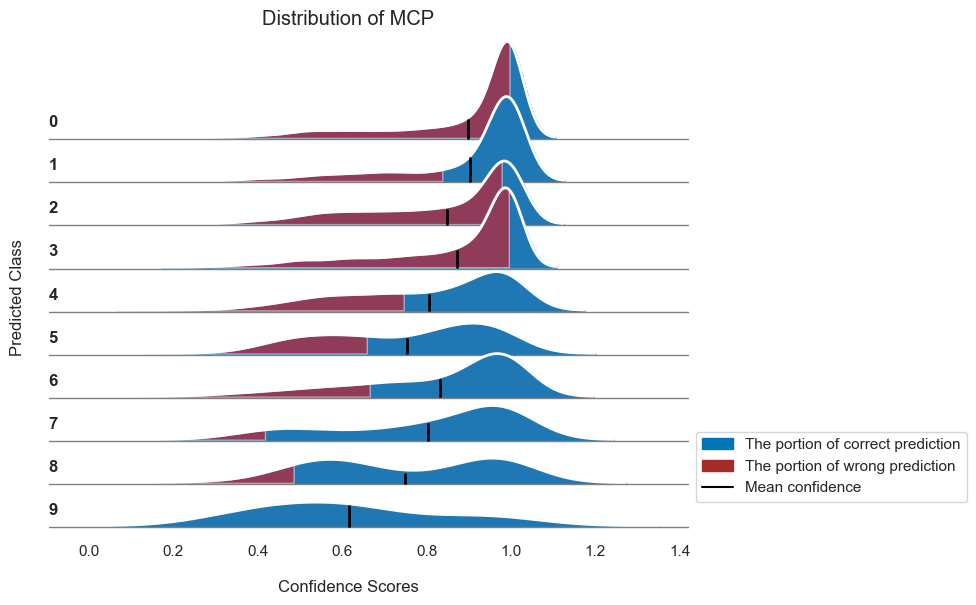

In [23]:
make_ridge_plot(df_mcp, thresholds_c_mcp, mean_conf_mcp, height_ratio = 0.15, title = 'Distribution of MCP')

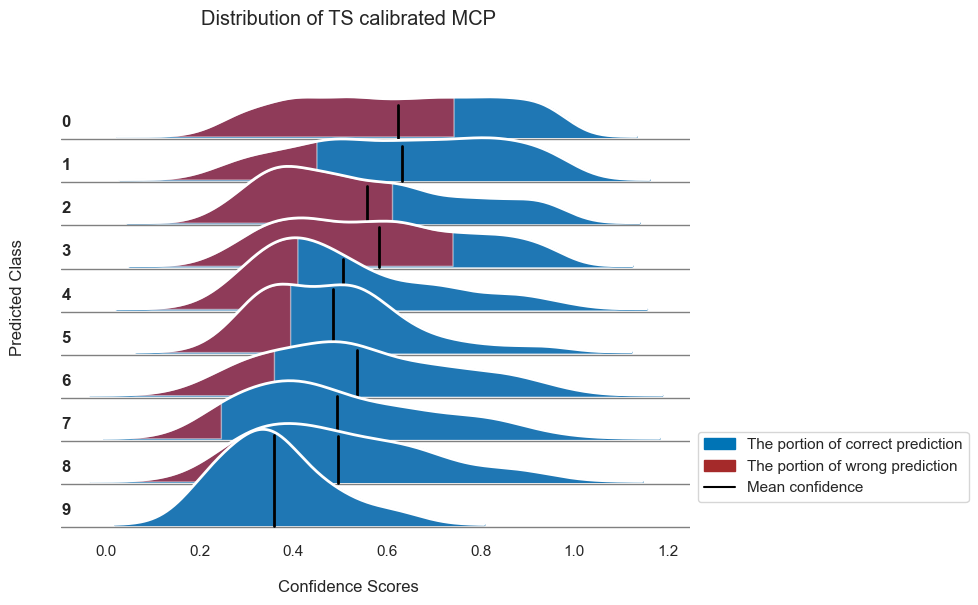

In [24]:
make_ridge_plot(df_baseline, thresholds_c_baseline, mean_conf_baseline, height_ratio = 0.27, title = 'Distribution of TS calibrated MCP')

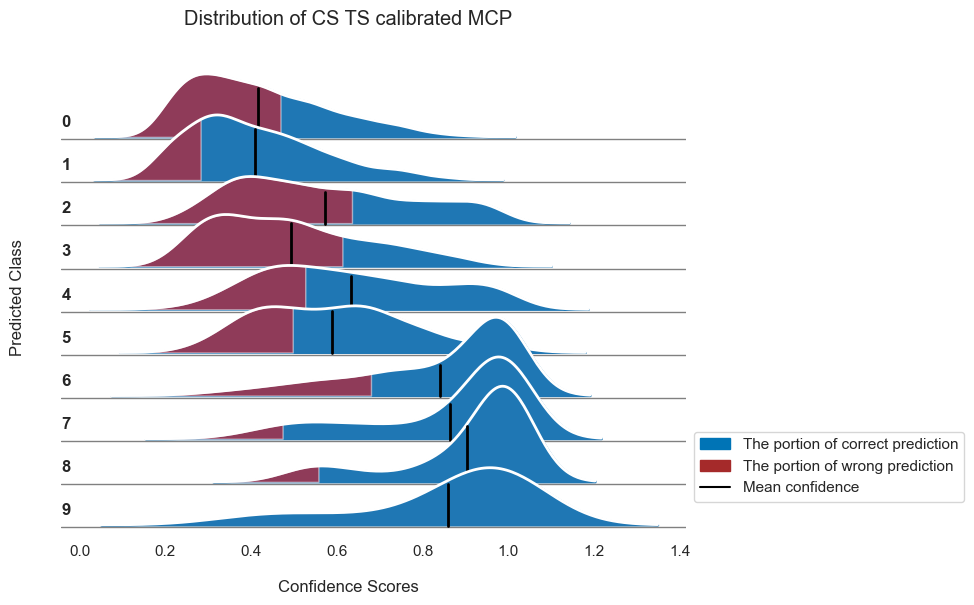

In [25]:
make_ridge_plot(df_cs, thresholds_c_cs, mean_conf_cs, height_ratio = 0.24, title = 'Distribution of CS TS calibrated MCP')

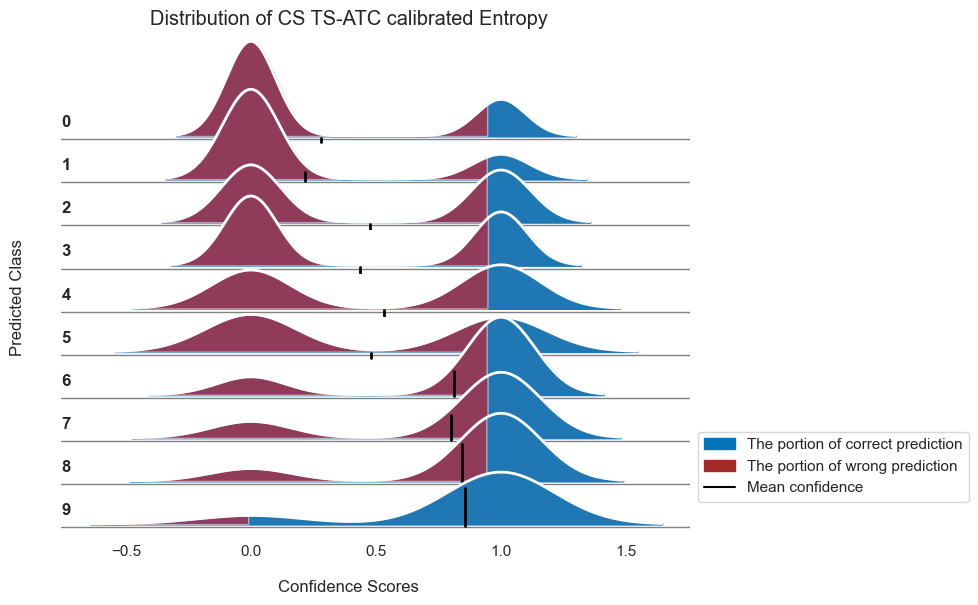

In [26]:
make_ridge_plot(df_cs_entropy, thresholds_c_cs_entropy, mean_conf_cs_entropy, height_ratio = 0.32, title = 'Distribution of CS TS-ATC calibrated Entropy')

## Making barplot for testing cases to show overall performance

In [27]:
def make_bar_plot(df, cls_acc, mean_conf, title = 'MCP Grouped by Predicted Class'):
    """Make the bar plot for the test case
    
    Args:
        df: The dataframe which contain all the information.
        cls_acc: A list of ``d`` mean accruacy.
        mean_conf: A list of ``d`` mean confidence.
        title: The given title to be shown.
    
    """
    
    # Set up the figure size and style
    sns.set(rc={'figure.figsize':(12,3)})
    sns.set_style("darkgrid")
    
    # Define the palette
    category_palette = {True: '#0074b6', False: '#a52a2a'}
    
    # Create the bar plot
    ax = sns.barplot(data=df, x="ID", y="Confidence Score", hue="Correctness",
                     order=df["ID"], palette=category_palette)
    
    # Set x-ticks to show every 10th group
    group_size = 11
    x_ticks = [i * group_size + group_size / 2 - 1 for i in range(len(df["ID"]) // group_size)]
    ax.set(xticks=x_ticks, xticklabels=np.arange(0, len(x_ticks)), xlabel="Sample ID Groups by Predicted Class")
    
    # Move the legend to the upper left
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    blue_patch = mpatches.Patch(color='#0074b6', label='Correct Prediction')
    red_patch = mpatches.Patch(color='#a52a2a', label='Wrong Prediction')
    green_patch = mpatches.Patch(color='#0074b6', alpha = 0.1, label='Mean Confidence')
    blank_patch = mpatches.Patch(color='#ffffff', ec='#000000' ,label='Class-Wise Accuracy', lw = 1)
    plt.legend(handles=[blue_patch, red_patch, green_patch, blank_patch], bbox_to_anchor=(1, 0.75), loc='upper left')
    
    ax.set_xlim(-2,110)
    
    # Fill the area between (0, 0) and (10, 1)
    ax.fill_between([-0.75, 9.75], 0, mean_conf[0], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([-0.75, 9.75], 0, cls_acc[0], facecolor='none', edgecolor='#000000')
    ax.fill_between([10.25, 20.75], 0, mean_conf[1], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([10.25, 20.75], 0, cls_acc[1], facecolor='none', edgecolor='#000000')
    ax.fill_between([21.25, 31.75], 0, mean_conf[2], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([21.25, 31.75], 0, cls_acc[2], facecolor='none', edgecolor='#000000')
    ax.fill_between([32.25, 42.75], 0, mean_conf[3], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([32.25, 42.75], 0, cls_acc[3], facecolor='none', edgecolor='#000000')
    ax.fill_between([43.25, 53.75], 0, mean_conf[4], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([43.25, 53.75], 0, cls_acc[4], facecolor='none', edgecolor='#000000')
    ax.fill_between([54.25, 64.75], 0, mean_conf[5], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([54.25, 64.75], 0, cls_acc[5], facecolor='none', edgecolor='#000000')
    ax.fill_between([65.25, 75.75], 0, mean_conf[6], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([65.25, 75.75], 0, cls_acc[6], facecolor='none', edgecolor='#000000')
    ax.fill_between([76.25, 86.75], 0, mean_conf[7], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([76.25, 86.75], 0, cls_acc[7], facecolor='none', edgecolor='#000000')
    ax.fill_between([87.25, 97.75], 0, mean_conf[8], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([87.25, 97.75], 0, cls_acc[8], facecolor='none', edgecolor='#000000')
    ax.fill_between([98.25, 108.75], 0, mean_conf[8], alpha=0.1, facecolor='#0074b6')
    ax.fill_between([98.25, 108.75], 0, cls_acc[8], facecolor='none', edgecolor='#000000')

    plt.title(title)
    # Show the plot
    plt.show()
    

In [28]:
def get_df_subset(df):
    """Get the subset of df with group-wise sampling, for visualization.
    
    Args:
        df: The dataframe which contain all the information.

    Returns:
        df_subset: The subsampled df.
    
    """

    def random_sample(group, n=10):
        return group.sample(n, random_state=1)
    
    # Apply the random_sample function to each group based on 'Prediction'
    df_subset = df.groupby('Prediction', group_keys=False).apply(random_sample, n=10)

    print(f"Analyzing data with {len(df_subset)} samples")
    
    df_space_0 = {'Confidence Score': 0, 'ID': 7001, 'Ground Truth': 0, 'Prediction': 0, 'Correctness': True}
    df_space_1 = {'Confidence Score': 0, 'ID': 7002, 'Ground Truth': 1, 'Prediction': 1, 'Correctness': True}
    df_space_2 = {'Confidence Score': 0, 'ID': 7003, 'Ground Truth': 2, 'Prediction': 2, 'Correctness': True}
    df_space_3 = {'Confidence Score': 0, 'ID': 7004, 'Ground Truth': 3, 'Prediction': 3, 'Correctness': True}
    df_space_4 = {'Confidence Score': 0, 'ID': 7005, 'Ground Truth': 4, 'Prediction': 4, 'Correctness': True}
    df_space_5 = {'Confidence Score': 0, 'ID': 7006, 'Ground Truth': 5, 'Prediction': 5, 'Correctness': True}
    df_space_6 = {'Confidence Score': 0, 'ID': 7007, 'Ground Truth': 6, 'Prediction': 6, 'Correctness': True}
    df_space_7 = {'Confidence Score': 0, 'ID': 7008, 'Ground Truth': 7, 'Prediction': 7, 'Correctness': True}
    df_space_8 = {'Confidence Score': 0, 'ID': 7009, 'Ground Truth': 8, 'Prediction': 8, 'Correctness': True}
    df_space_9 = {'Confidence Score': 0, 'ID': 7010, 'Ground Truth': 9, 'Prediction': 9, 'Correctness': True}
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_0])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_1])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_2])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_3])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_4])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_5])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_6])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_7])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_8])], ignore_index=True)
    df_subset = pd.concat([df_subset, pd.DataFrame([df_space_9])], ignore_index=True)
    #
    # First sorting by 'Prediction' in ascending order
    df_subset = df_subset.sort_values(by="Prediction", ascending=True, na_position='first')
    
    # Define a custom sorting key function
    def custom_sort(row):
        return row['Prediction'], -row['Confidence Score']  # Note the negative sign for descending order
    
    # Apply the custom sorting key function to the DataFrame
    df_subset['Sorting_Key'] = df_subset.apply(custom_sort, axis=1)
    df_subset = df_subset.sort_values(by='Sorting_Key')
    
    # Drop the temporary column
    df_subset = df_subset.drop(columns=['Sorting_Key'])

    return df_subset

Analyzing data with 100 samples


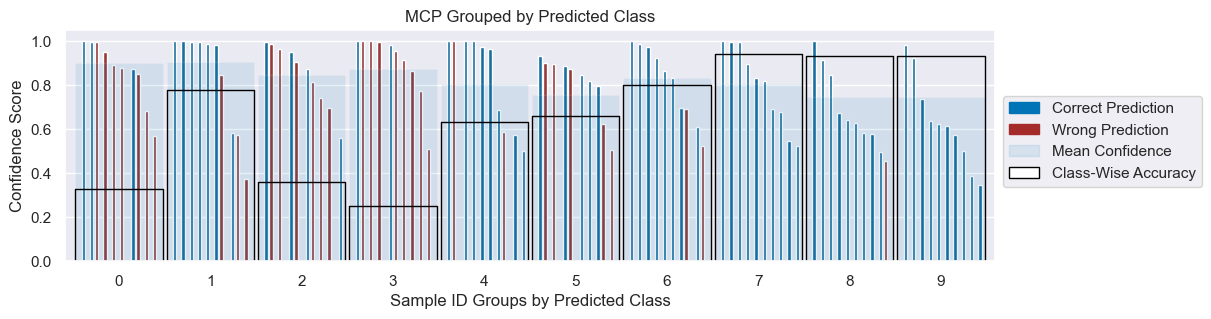

In [29]:
make_bar_plot(get_df_subset(df_mcp), cls_acc_mcp, mean_conf_mcp, title = 'MCP Grouped by Predicted Class')

Analyzing data with 100 samples


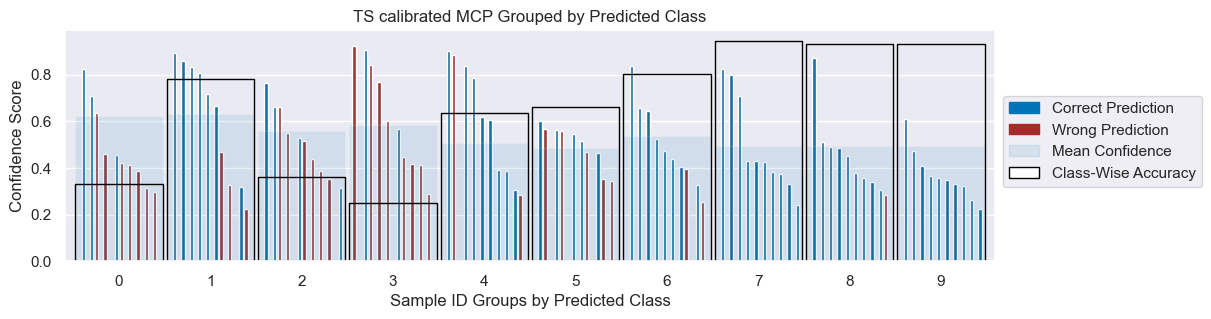

In [30]:
make_bar_plot(get_df_subset(df_baseline), cls_acc_baseline, mean_conf_baseline, title = 'TS calibrated MCP Grouped by Predicted Class')

Analyzing data with 100 samples


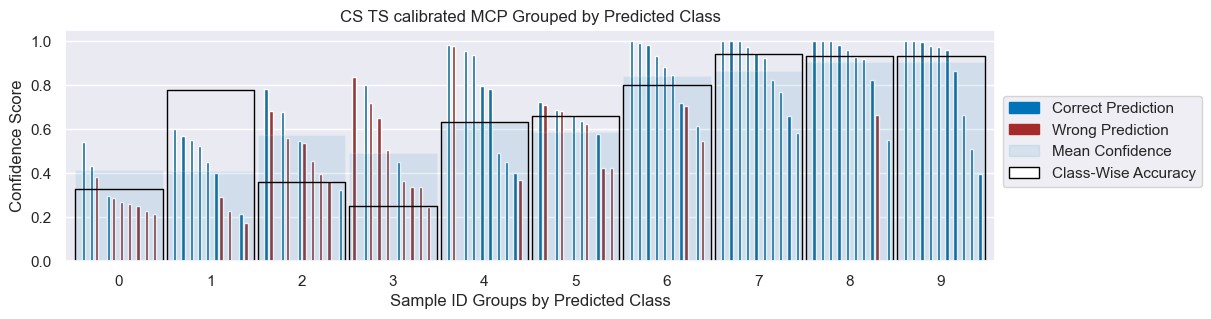

In [31]:
make_bar_plot(get_df_subset(df_cs), cls_acc_cs, mean_conf_cs, title = 'CS TS calibrated MCP Grouped by Predicted Class')

Analyzing data with 100 samples


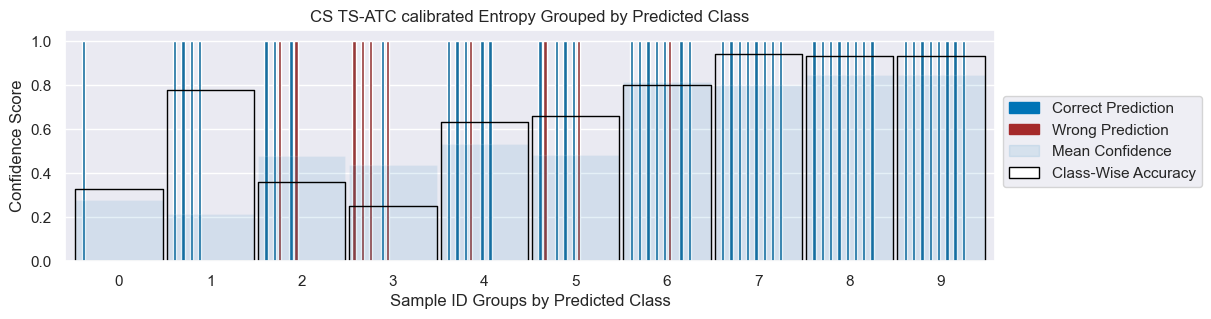

In [32]:
make_bar_plot(get_df_subset(df_cs_entropy), cls_acc_cs_entropy, mean_conf_cs_entropy, title = 'CS TS-ATC calibrated Entropy Grouped by Predicted Class')

## Making some visualizatin of images

In [33]:
cifarlabel = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def investigate_score(conf, logits, gt, title = 'The 5 Lowest and Highest Confidence Score of MCP'):
    """Investigate the lowest and highest score
    
    Args:
        conf: The confidence score of shape ``(n, )``.
        logits: The network output (logits) of shape ``(n, d)`` for classification. 
        gt: The cooresponding annotation of shape ``(n, )`` for classification.
        title: The given title to be shown.
    
    """

    conf_sort = np.argsort(conf)
    sellist = np.concatenate((conf_sort[:5], conf_sort[-5:]))
    imgc_load_10 = imgc_load_5[sellist, :, :, :]

    conf_10 = conf[sellist]
    pred_10 = np.argmax(logits, axis=1)[sellist]
    gt_10 = gt[sellist]


    # Set up the figure size
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 9))
    
    # Loop through each image and plot it with descriptions
    for i in range(10):
        row = (i // 5) * 2
    
        axes[row, i % 5].imshow(imgc_load_10[i])
        axes[row, i % 5].axis('off')  # Turn off axis labels
    
        # Add descriptions below each image
        axes[row + 1, i % 5].text(0.5, 0.63, f'Model Confidence is {conf_10[i]:.3f}', ha='center', va='center', fontsize=12)
        axes[row + 1, i % 5].text(0.5, 0.53, f'Ground Truth is {cifarlabel[gt_10[i]]}', ha='center', va='center', fontsize=12)
        axes[row + 1, i % 5].text(0.5, 0.43, f'Prediction is {cifarlabel[pred_10[i]]}', ha='center', va='center', fontsize=12)
        axes[row + 1, i % 5].axis('off')  # Turn off axis labels for the second row
    
    # Add a title to the entire figure
    plt.suptitle(title, fontsize=20)
    
    # Adjust layout for better spacing
    plt.subplots_adjust(wspace=0., hspace=-0.3)  # Adjust spacing parameters
    
    # Show the plot
    plt.show()

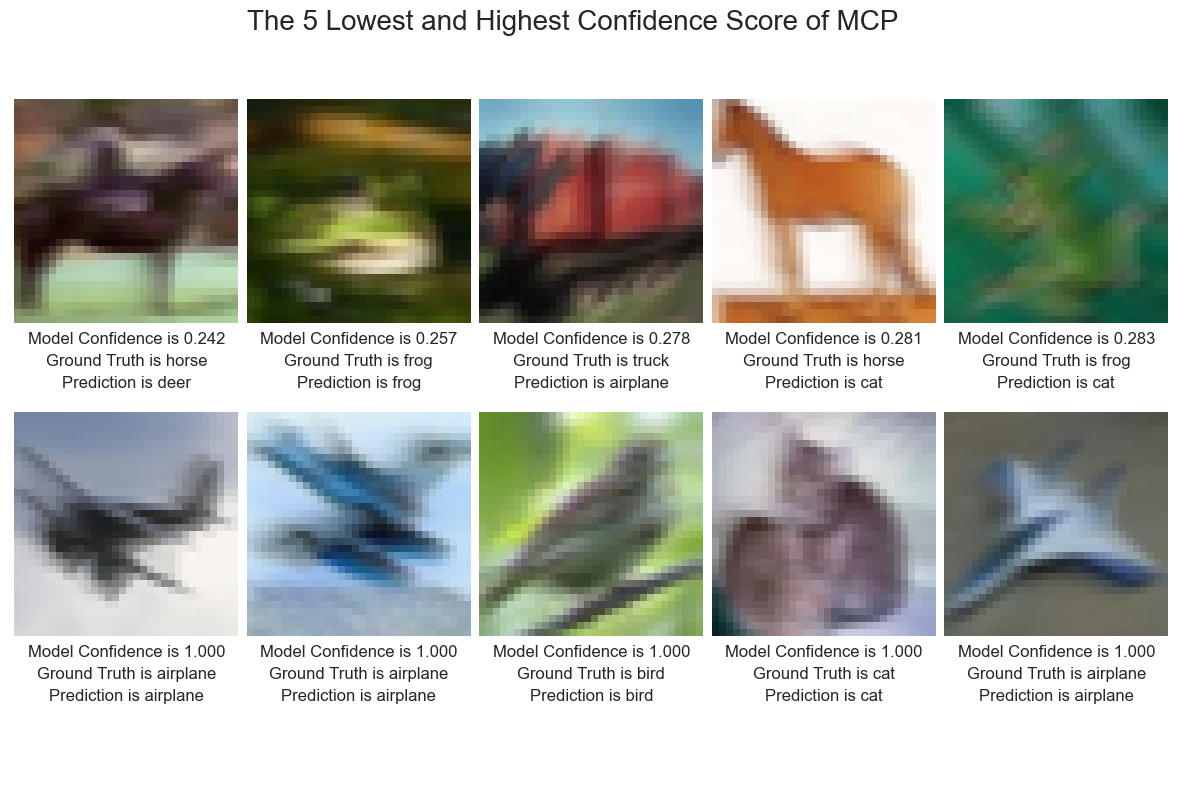

In [34]:
investigate_score(conf_mcp, logits_tests[0], gt_tests[0], title = 'The 5 Lowest and Highest Confidence Score of MCP')

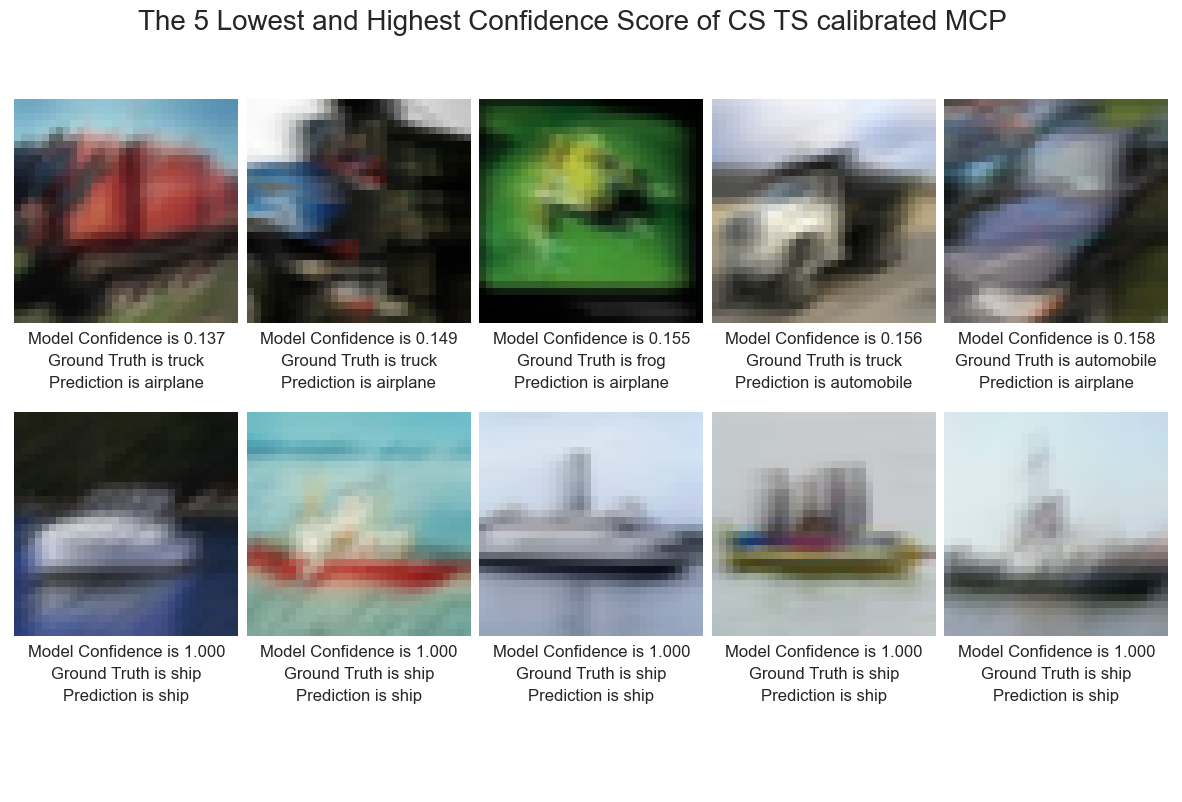

In [35]:
investigate_score(conf_cs, logits_tests[0], gt_tests[0], title = 'The 5 Lowest and Highest Confidence Score of CS TS calibrated MCP')

## Performance tracking

In [36]:
perf = moval_model_cs.fitted_perf

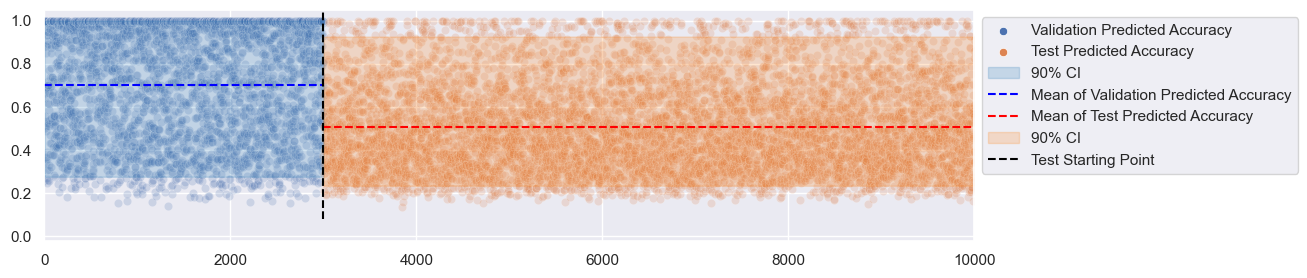

In [45]:
ax = sns.scatterplot(x=range(len(perf)), y=perf, alpha=0.2,label='Validation Predicted Accuracy')

ax = sns.scatterplot(x=range(len(perf), len(perf)+len(conf_cs)), y=conf_cs, alpha=0.2,label='Test Predicted Accuracy')

# Calculate the 5th and 95th percentiles
percentiles = np.percentile(perf, [5, 95])

# Shade the area between the 5th and 95th percentiles
plt.fill_between(x=range(len(perf)), y1=percentiles[0], y2=percentiles[1], color='#1f77b4', alpha=0.2, label='90% CI')
# Calculate the mean of the data
mean_value = sum(perf) / len(perf)

# Draw a horizontal line at the mean
plt.axhline(y = mean_value, color='blue', linestyle='--', label='Mean of Validation Predicted Accuracy', xmin=0, xmax=(len(perf) - 1) / (len(perf) + len(conf_cs) - 1))


mean_value_new = sum(conf_cs) / len(conf_cs)

# Draw a horizontal line at the mean
plt.axhline(y = mean_value_new, color='red', linestyle='--', label='Mean of Test Predicted Accuracy', xmin=len(perf) / (len(perf) + len(conf_cs) - 1), xmax=1)


percentiles = np.percentile(conf_cs, [5, 95])

# Shade the area between the 5th and 95th percentiles
plt.fill_between(x=range(len(perf), len(perf)+len(conf_cs)), y1=percentiles[0], y2=percentiles[1], color='#ff7f0e', alpha=0.2, label='90% CI')

ymin, ymax = plt.ylim()
plt.axvline(x=len(perf) - 1,ymin=ymin, ymax=ymax, color='black', linestyle='--', label='Test Starting Point')

ax.set(ylim=(-0.02, 1.05))
ax.set(xlim=(0, len(perf)+len(conf_cs)))

# Show the legend for both scatter plots and lines without alpha
legend = plt.legend()
legend.legendHandles[0]._alpha = 1  # Set marker size for the scatter plots in the legend
legend.legendHandles[1]._alpha = 1
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))